In [54]:
import pandas as pd
import matplotlib.pyplot as plt

In [55]:
dataset = pd.read_csv("datasets/essential_genes.csv", sep=';', header=None)
print(dataset.shape)

(28166, 15)


In [56]:
# remove rows with "Notavailablenow." in the last column
dataset = dataset[dataset[dataset.shape[1]-1] != "Notavailablenow."]

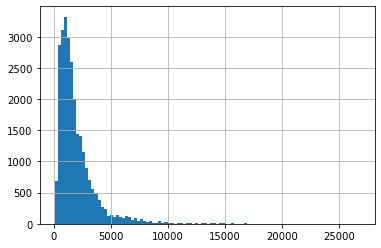

Total sequences: 26790
-------------------------------
Top 5 longest sequences:
21026    26778
1223     26394
2298     25578
1661     23253
3657     23253
-------------------------------
Top 5 shortest sequences:
7283      78
9436      78
26992    135
5984     144
8058     144
-------------------------------
Average length: 1951.3291899962674
-------------------------------
Mode: 0    1041
1    1083
-------------------------------
Most common:
1041     87
1083     87
1314     85
555      80
1005     79
1371     79
585      77
1221     77
1131     77
1428     76
1395     75
1143     74
786      71
1191     70
606      68
1515     68
996      67
882      67
597      66
684      66
642      63
972      63
1530     62
984      62
816      62
1452     61
618      61
1188     61
1359     61
1212     60
1020     60
1443     60
1299     60
537      60
477      60
774      60
429      59
615      58
627      58
795      58
1320     58
1647     57
543      57
948      57
942      57
1086     56


In [57]:
# calculate length of each gene (last row)
dataset[dataset.shape[1] - 1] = dataset[dataset.shape[1] - 1].str.len()

# remove rows that have a length bigger than 27000
dataset = dataset[dataset[dataset.shape[1] - 1] <= 27000]

# build a histogram of the lengths of the genes
dataset[dataset.shape[1] - 1].hist(bins=100)
plt.show()

print("Total sequences:", dataset.shape[0])

print("-------------------------------")

print("Top 5 longest sequences:")
print(dataset[dataset.shape[1] - 1].nlargest(5).to_string())

print("-------------------------------")

print("Top 5 shortest sequences:")
print(dataset[dataset.shape[1] - 1].nsmallest(5).to_string())

print("-------------------------------")

print("Average length:", dataset[dataset.shape[1] - 1].mean())

print("-------------------------------")

print("Mode:", dataset[dataset.shape[1] - 1].mode().to_string())

print("-------------------------------")

print("Most common:")
print(dataset[dataset.shape[1] - 1].value_counts().to_string())